In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

#Alpha vantage

2OQT6WT9WH45WTK5

In [3]:
myticker = "AAPL"
df = pd.read_csv(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={myticker}&apikey=2OQT6WT9WH45WTK5&datatype=csv')
df

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2023-04-24,165.000,165.6000,163.890,165.33,165.330000,41949581,0.0,1.0
1,2023-04-21,165.050,166.4521,164.490,165.02,165.020000,58337341,0.0,1.0
2,2023-04-20,166.090,167.8700,165.560,166.65,166.650000,52456377,0.0,1.0
3,2023-04-19,165.800,168.1600,165.540,167.63,167.630000,47720166,0.0,1.0
4,2023-04-18,166.100,167.4100,165.650,166.47,166.470000,49923008,0.0,1.0
...,...,...,...,...,...,...,...,...,...
95,2022-12-05,147.770,150.9199,145.770,146.63,146.407011,68826442,0.0,1.0
96,2022-12-02,145.960,148.0000,145.650,147.81,147.585216,65447446,0.0,1.0
97,2022-12-01,148.210,149.1300,146.610,148.31,148.084456,71250416,0.0,1.0
98,2022-11-30,141.395,148.7200,140.550,148.03,147.804882,111380880,0.0,1.0


In [5]:
df1 = df.reset_index()["close"]
df1.shape

(100,)

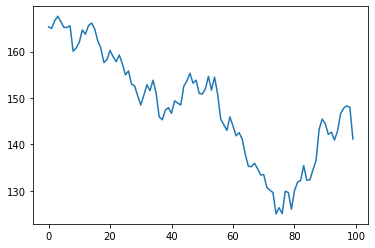

In [6]:
df1.plot()
plt.show()

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.94602206],
       [0.93874677],
       [0.9770007 ],
       [1.        ],
       [0.97277634],
       [0.94367519],
       [0.94320582],
       [0.95141985],
       [0.82328092],
       [0.83970899],
       [0.86857545],
       [0.93029805],
       [0.90917625],
       [0.95306266],
       [0.96573574],
       [0.93593053],
       [0.87632011],
       [0.83900493],
       [0.76578268],
       [0.78056794],
       [0.82680122],
       [0.79582258],
       [0.77000704],
       [0.80403661],
       [0.75991551],
       [0.70359071],
       [0.72353908],
       [0.65641868],
       [0.64703121],
       [0.59727763],
       [0.55104436],
       [0.60009387],
       [0.65360244],
       [0.62379723],
       [0.67613236],
       [0.61042009],
       [0.4902605 ],
       [0.4761793 ],
       [0.52546351],
       [0.53743253],
       [0.50903544],
       [0.57216616],
       [0.56066651],
       [0.55057498],
       [0.64609247],
       [0.67331612],
       [0.71133537],
       [0.661

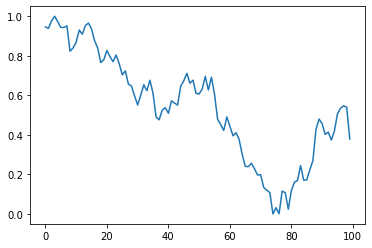

In [8]:
plt.plot(df1)
plt.show()

In [9]:
scaler.inverse_transform(df1[1].reshape(-1, 1))

array([[165.02]])

# Dataset

In [10]:
df_len = int(len(df1))
training_size = int(df_len * 0.65)
testing_size = df_len - training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [249]:
class StockDataset(Dataset):
    def __init__(self,data,seq_len = 20):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) : # start from x and prediction is x+20
        # return x, y
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]


train_dataset = StockDataset(train_data) 
test_dataset = StockDataset(test_data)
full_dataset = StockDataset(df1)

In [276]:
batch_size = 4
train_dataloader = DataLoader(train_dataset,batch_size,drop_last=True)
test_dataloader = DataLoader(test_dataset,batch_size,drop_last=True)
full_dataloader = DataLoader(full_dataset,batch_size,drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

count = 0
for data in train_dataloader:
    count +=1
    print(data[1].shape)
print(count)
print(training_size)
# so the total should be 44 y for 65 data points
# 20 lookback

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
11
65


# Model

In [238]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self,x):
        hn,cn  = self.init()
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0


input_dim = 1 
hidden_size = 50
num_layers = 3
model = Lstm_model(input_dim , hidden_size , num_layers).to(device)


In [239]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [232]:
def train(dataloader):
    hn , cn = model.init()
    model.train()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        # x in shape of seq_len, batch size, 1
        out , hn , cn = model(x.reshape(20,batch_size,1),hn,cn) 
        loss = loss_fn(out.reshape(batch_size) , y)
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"train loss: {loss:>7f} ")

In [279]:
def test(dataloader):
    res = torch.tensor([], dtype=torch.int64)
    hn , cn = model.init()
    model.eval()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(20,batch_size,1),hn,cn)
        #print(out)
        res =  torch.cat((out,res), 0) 
        loss = loss_fn(out.reshape(batch_size) , y)
       
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"test loss: {loss:>7f} ")
                  
    return res

In [280]:
epochs = 200
for epoch in range(epochs):
    print(f"epoch {epoch} ")
    train(train_dataloader)
    output0 = test(train_dataloader)
    output = test(test_dataloader)

epoch 0 
train loss: 0.002732 
test loss: 0.001263 
test loss: 0.001140 
epoch 1 
train loss: 0.006487 
test loss: 0.003664 
test loss: 0.001139 
epoch 2 
train loss: 0.002379 
test loss: 0.001645 
test loss: 0.001191 
epoch 3 
train loss: 0.001455 
test loss: 0.001600 
test loss: 0.001197 
epoch 4 
train loss: 0.001499 
test loss: 0.001140 
test loss: 0.001199 
epoch 5 
train loss: 0.000806 
test loss: 0.000661 
test loss: 0.001164 
epoch 6 
train loss: 0.000906 
test loss: 0.000743 
test loss: 0.001183 
epoch 7 
train loss: 0.000667 
test loss: 0.000562 
test loss: 0.001182 
epoch 8 
train loss: 0.001055 
test loss: 0.000813 
test loss: 0.001270 
epoch 9 
train loss: 0.000702 
test loss: 0.000555 
test loss: 0.001226 
epoch 10 
train loss: 0.001147 
test loss: 0.000804 
test loss: 0.001307 
epoch 11 
train loss: 0.000936 
test loss: 0.000628 
test loss: 0.001236 
epoch 12 
train loss: 0.001720 
test loss: 0.001042 
test loss: 0.001356 
epoch 13 
train loss: 0.001443 
test loss: 0.000

train loss: 0.000809 
test loss: 0.000718 
test loss: 0.010829 
epoch 112 
train loss: 0.001427 
test loss: 0.000954 
test loss: 0.010367 
epoch 113 
train loss: 0.001670 
test loss: 0.000844 
test loss: 0.017939 
epoch 114 
train loss: 0.003968 
test loss: 0.001434 
test loss: 0.008819 
epoch 115 
train loss: 0.004187 
test loss: 0.001795 
test loss: 0.016400 
epoch 116 
train loss: 0.009946 
test loss: 0.007444 
test loss: 0.006124 
epoch 117 
train loss: 0.000938 
test loss: 0.000982 
test loss: 0.023037 
epoch 118 
train loss: 0.000797 
test loss: 0.000916 
test loss: 0.003642 
epoch 119 
train loss: 0.003526 
test loss: 0.000863 
test loss: 0.004653 
epoch 120 
train loss: 0.008739 
test loss: 0.006011 
test loss: 0.003102 
epoch 121 
train loss: 0.003423 
test loss: 0.004056 
test loss: 0.004513 
epoch 122 
train loss: 0.004445 
test loss: 0.003278 
test loss: 0.005143 
epoch 123 
train loss: 0.001400 
test loss: 0.001243 
test loss: 0.005401 
epoch 124 
train loss: 0.001339 
tes

In [291]:
print(output.shape)
res = output.detach().numpy()
print(res.shape)

torch.Size([12, 1])
(12, 1)


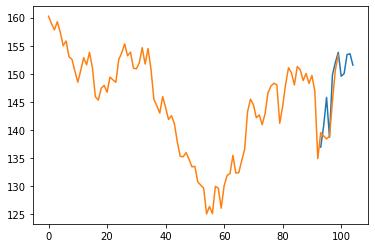

In [297]:
#res = np.concatenate((output0.detach().numpy(),output.detach().numpy()))
res1 = scaler.inverse_transform(res)
plt.plot(np.arange(93,105,1),np.array(res1))
plt.plot(df1)

In [236]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(20,4,1)
            pred = model(x,hn,cn)[0]
            pred = scaler.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scaler.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        print(pred_arr[11],y_arr[11])
        return math.sqrt(mean_squared_error(y_arr,pred_arr))
    

In [237]:
# calculating final loss metrics
print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")

153.37825 151.92
train mse loss 2.3234842630489205
140.20488 138.88
test mse loss 6.479403508836462
